In [1]:
import numpy as np
import pandas as pd
from edempy import Deck
from extrapolation import extrapolation
from LaceyClass import LaceyMixingAnalyzer
import matplotlib.pyplot as plt
from rnn.data_loader_rnn import RNNLoader
from rnn.rnn_extrap import plot_particles, import_dict
import matplotlib.pyplot as plt


sim_names = ["Rot_drum_mono", "Rot_drum_binary_mixed", "Rot_drum_400k"]
sim_name = sim_names[-1]
sim_path =rf"V:\GrNN_EDEM-Sims\{sim_name}.dem"

In [2]:
#simulation parameters
start_t = 1
end_t = 20
domain_x = (-0.07, 0.07)       
domain_y = (-0.025, 0.025)
domain_z = (-0.07, 0.03)
num_bins = 10
direction = "y"

extrap = extrapolation(start_t, end_t, sim_path, domain_x, domain_y, domain_z, num_bins, direction)

801


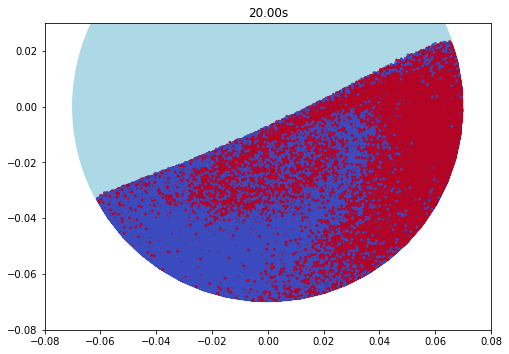

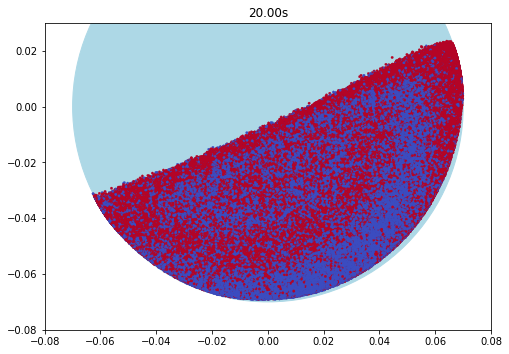

array([[ 2.14216225e-02, -2.50000000e-02, -2.16220131e-02,
         1.30899694e-06,  3.59549000e+05,  1.00000000e+00],
       [ 1.80354760e-02, -2.50000000e-02, -1.94407598e-02,
         1.30899694e-06,  2.85489000e+05,  0.00000000e+00],
       [ 2.41867941e-02, -2.50000000e-02, -2.08470959e-02,
         1.30899694e-06,  2.26960000e+04,  1.00000000e+00],
       ...,
       [-1.92809142e-02,  1.36509145e-02, -5.62864627e-02,
         1.30899694e-06,  6.10290000e+04,  1.00000000e+00],
       [ 3.00188490e-03,  1.37983711e-02, -5.97659377e-02,
         1.30899694e-06,  8.71710000e+04,  0.00000000e+00],
       [-2.20819748e-02,  1.49426638e-02, -6.13865135e-02,
         1.30899694e-06,  1.98074000e+05,  0.00000000e+00]])

In [8]:
id_dict_path = rf"V:\GrNN_EDEM-Sims\{sim_name}_data\Export_Data"
id_dict = import_dict(id_dict_path, "id_dict")

t1 = 20

t1_index = extrap.find_nearest(extrap.deck.timestepValues, t1)
print(t1_index)
t1_data = extrap.get_particle_coords(t1_index)

id_dict = import_dict(id_dict_path, "id_dict")
plot_particles(t1_data, id_dict, True, t1)

z_max = np.amax(t1_data[:, 2])


#predicted_path = rf"V:\GrNN_EDEM-Sims\{sim_name}_data\Export_Data\RNNSR_plots\35_12_35_sl15_3_6.5_0.05s_plots_30ep_128batch\timestep_data\20.00.csv"
predicted_path = rf"V:\GrNN_EDEM-Sims\{sim_name}_data\Export_Data\RNNSR_plots\23_8_23_sl15_3_5_0.05s_plots_20ep_64batch\timestep_data\20.00.npy"
predicted_path = rf"V:\GrNN_EDEM-Sims\{sim_name}_data\Export_Data\RNNSR_plots\35_12_35_sl30_3_6.5_0.05s_plots_30ep_128batch\timestep_data\20.00.npy"
predicted_path = rf"V:\GrNN_EDEM-Sims\{sim_name}_data\Export_Data\RNNSR_plots\35_12_35_sl25_3_5_0.03s_plots_20ep_128batch\timestep_data\20.01.npy"


t2_data = np.load(predicted_path)

new_column = np.ones((t2_data.shape[0]))
t2_data = np.insert(t2_data, -1, new_column*t1_data[0,-2], axis=1)
plot_particles(t2_data, id_dict, True, t1)



In [9]:
def slice_positions_1d(data, domain, num_bins, direction='x'):
    if direction == 'x':
        component = 0
    elif direction == 'y':
        component = 1
    elif direction == 'z':
        component = 2
    else:
        component = 0
    
    bin_edges = np.linspace(domain[0], domain[1], num_bins, endpoint=False)
    bin_indx = np.digitize(data[:, component], bin_edges, right=True)
    
    # Initialize an empty list to store slices
    slices_t1 = []
    
    # Iterate over bin indices
    for bin_idx in range(1, num_bins + 1):
        # Check if any particles belong to the current bin
        if np.any(bin_indx == bin_idx):
            # Extract particles belonging to the bin
            bin_particles = data[bin_indx == bin_idx, :]
        else:
            # If no particles, create an array of zeros
            bin_particles = np.zeros((0, data.shape[1]))
        
        # Append bin particles to slices list
        slices_t1.append(bin_particles)
    
    return slices_t1

def get_stats(ground_truth, prediction):

    #RMSE calculation
    differences = ground_truth - prediction
    squared_differences = differences ** 2
    mean_squared_difference = np.mean(squared_differences)
    rmse = np.sqrt(mean_squared_difference)

    #R2 calculation
    mean_ground_truth = np.mean(ground_truth)
    tss = np.sum((ground_truth - mean_ground_truth) ** 2)
    rss = np.sum(differences ** 2)
    r_squared = 1 - (rss / tss)

    #MAE calculation
    absolute_differences = np.abs(ground_truth - prediction)
    mae = np.mean(absolute_differences)

    return rmse, r_squared, mae



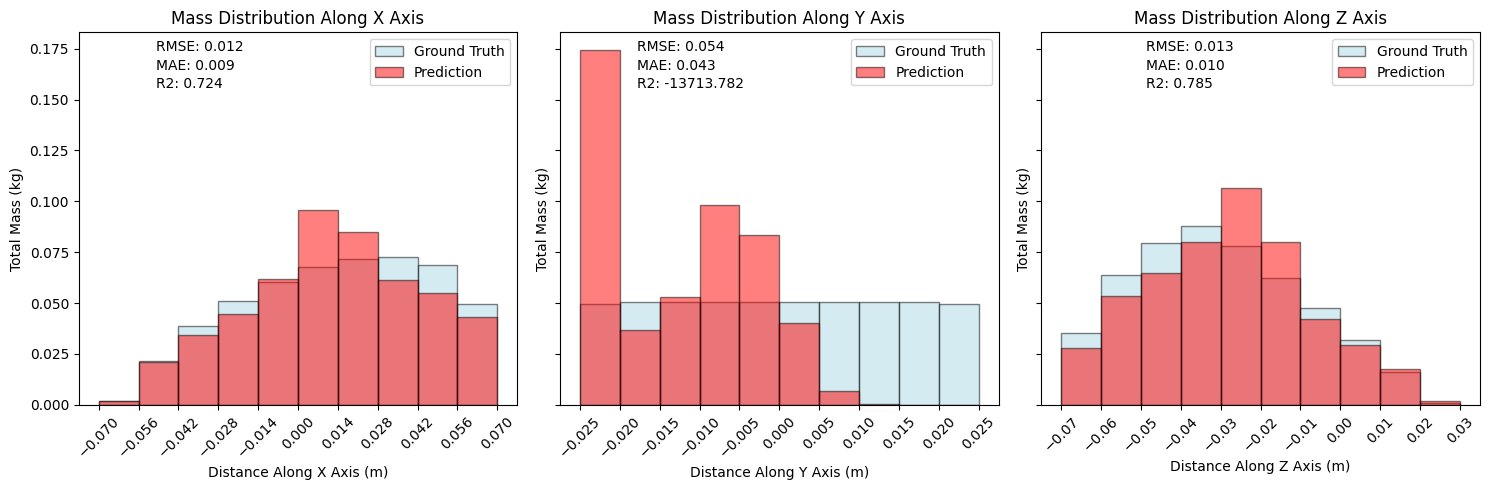

In [10]:
direction = "y"
bin_count = 10
domain_x = (-0.07, 0.07)
domain_y = (-0.025, 0.025)
domain_z = (-0.07, 0.03)

domains = {
    "x": domain_x,
    "y": domain_y,
    "z": domain_z
}
# Define a color map for differentiating between t1_data and t2_data
colors = ['lightblue', 'red']

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=1, dpi=100)


rmses = []
r_squareds = []
maes = []


# Iterate over each direction
for i, direction in enumerate(domains.keys()):
    bin_length = (domains[direction][1] - domains[direction][0]) / bin_count

    #slice domain and calculate mass distrubtion
    bins = np.linspace(domains[direction][0], domains[direction][1], bin_count + 1)
    slices_dem = slice_positions_1d(t1_data, domains[direction], bin_count, direction)
    slices_pred = slice_positions_1d(t2_data, domains[direction], bin_count, direction)
    masses_dem = [np.sum(slice[:, 3]) for slice in slices_dem]
    masses_pred = [np.sum(slice[:, 3]) for slice in slices_pred]

    # plot bar graph
    axs[i].bar(bins[:-1], masses_dem, width=np.diff(bins), edgecolor="k", align="edge", color=colors[0], label='Ground Truth', alpha=0.5)
    axs[i].bar(bins[:-1], masses_pred, width=np.diff(bins), edgecolor="k", align="edge", color=colors[1], label='Prediction', alpha=0.5)

    # graph setting
    axs[i].set_xlabel(f'Distance Along {direction.capitalize()} Axis (m)')
    axs[i].set_ylabel('Total Mass (kg)')
    axs[i].set_title(f'Mass Distribution Along {direction.capitalize()} Axis')
    axs[i].set_xticks(bins)
    axs[i].tick_params(axis='x', rotation=45)
    axs[i].legend()

    rmse, r_squared, mae = get_stats(np.array(masses_dem), np.array(masses_pred))

    rmses.append(rmse)
    r_squareds.append(r_squared)
    maes.append(mae)

    new_max = axs[i].get_ylim()[1]


for i in range(3):
    axs[i].text(x=0.65*axs[i].get_xlim()[0], y=0.95*axs[i].get_ylim()[1], s=f"RMSE: {rmses[i]:.3f}")
    axs[i].text(x=0.65*axs[i].get_xlim()[0], y=0.9*axs[i].get_ylim()[1], s=f"MAE: {maes[i]:.3f}")
    axs[i].text(x=0.65*axs[i].get_xlim()[0], y=0.85*axs[i].get_ylim()[1], s=f"R2: {r_squareds[i]:.3f}")

# Adjust layout to prevent clipping of labels
plt.tight_layout()

# Display the plot
plt.show()

In [3]:
import os
from scipy.spatial import ConvexHull

# Folder containing .npy files
folder_path = rf"V:\GrNN_EDEM-Sims\{sim_name}_data\Export_Data\RNNSR_plots"

# Function to calculate volume of convex hull
def calculate_volume(points):
    hull = ConvexHull(points)
    return hull.volume

# # Iterate through all subfolders in the folder_path
# for subfolder in os.listdir(folder_path):
#     subfolder_path = os.path.join(folder_path, subfolder)
    
#     # Check if it's a directory
#     if os.path.isdir(subfolder_path):
#         print(subfolder_path)

#         sub_sub_path = os.path.join(subfolder_path, "timestep_data")
        
#         # Check if the sub-subfolder "timestep_data" exists
#         if os.path.exists(sub_sub_path):
#             convex_volumes = []
#             timestep_values = []  # List to store volumes
#             print(sub_sub_path)

#             # Iterate through .npy files in the sub-subfolder
#             timestep_files = [file for file in os.listdir(sub_sub_path) if file.lower().endswith('.npy') or file.lower().endswith('.csv')]
#             timestep_files = sorted(timestep_files, key=lambda x: float(x[:-4]))  # Sort files by name

#             for file_name in timestep_files:
#                 print(file_name)
#                 timestep_value = file_name[:-4]
#                 timestep_values.append(timestep_value)
#                 file_path = os.path.join(sub_sub_path, file_name)
#                 # Load points from .npy file
#                 try:
#                     points = np.load(file_path)[:,:3]
#                 except:
#                     points = np.genfromtxt(file_path, delimiter=",")[:,:3]
#                 # Calculate volume and append to list
#                 volume = calculate_volume(points)
#                 convex_volumes.append(volume)

#             # Save convex volumes to convex_volumes.npy
#             np.save(os.path.join(subfolder_path, "convex_volumes.npy"), np.column_stack((timestep_values,convex_volumes)))


In [20]:
delta_t = 0.05
dem_volumes = []

for timestep in np.arange(extrap.start_t, extrap.end_t+delta_t, delta_t):
    timestep_i = extrap.find_nearest(timestep, extrap.deck.timestepValues)
    print(timestep_i)
    
    dem_particles = extrap.get_particle_coords(timestep_i)[:,:3]
    volume = calculate_volume(dem_particles)
    dem_volumes.append(volume)


100
105
110
115
120
125
130
135
140
145
150
155
160
166
171
176
181
186
191
196
201
206
211
216
221
226
231
236
241
246
251
256
261
266
271
276
281
286
291
296
301
306
311
316
321
326
331
336
341
346
351
356
361
366
371
376
381
386
391
396
401
406
411
416
421
426
431
436
441
446
451
456
461
466
471
476
481
486
491
496
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670


In [5]:
timestep_path = rf"V:\GrNN_EDEM-Sims\{sim_name}_data\Export_Data\RNNSR_plots\35_3_35_sl30_3_6.5_0.05s_plots_30ep_128batch\timestep_data"
convex_volumes = []
timestep_values = [] 


# Iterate through .npy files in the sub-subfolder
timestep_files = [file for file in os.listdir(timestep_path) if file.lower().endswith('.npy') or file.lower().endswith('.csv')]
timestep_files = sorted(timestep_files, key=lambda x: float(x[:-4]))  # Sort files by name

for file_name in timestep_files:
    print(file_name)
    timestep_value = file_name[:-4]
    timestep_values.append(timestep_value)
    file_path = os.path.join(timestep_path, file_name)
    # Load points from .npy file
    try:
        points = np.load(file_path)[:,:3]
    except:
        points = np.genfromtxt(file_path, delimiter=",")[:,:3]
    # Calculate volume and append to listmode
    volume = calculate_volume(points)
    convex_volumes.append(volume)

# Save convex volumes to convex_volumes.npy
np.save(os.path.join(os.path.dirname(timestep_path), "convex_volumes.npy"), np.column_stack((np.array(timestep_values).astype(float),np.array(convex_volumes).astype(float))))

6.45.npy
6.50.npy
6.55.npy
6.60.npy
6.65.npy
6.70.npy
6.75.npy
6.80.npy
6.85.npy
6.90.npy
6.95.npy
7.00.npy
7.05.npy
7.10.npy
7.15.npy
7.20.npy
7.25.npy
7.30.npy
7.35.npy
7.40.npy
7.45.npy
7.50.npy
7.55.npy
7.60.npy
7.65.npy
7.70.npy
7.75.npy
7.80.npy
7.85.npy
7.90.npy
7.95.npy
8.00.npy
8.05.npy
8.10.npy
8.15.npy
8.20.npy
8.25.npy
8.30.npy
8.35.npy
8.40.npy
8.45.npy
8.50.npy
8.55.npy
8.60.npy
8.65.npy
8.70.npy
8.75.npy
8.80.npy
8.85.npy
8.90.npy
8.95.npy
9.00.npy
9.05.npy
9.10.npy
9.15.npy
9.20.npy
9.25.npy
9.30.npy
9.35.npy
9.40.npy
9.45.npy
9.50.npy
9.55.npy
9.60.npy
9.65.npy
9.70.npy
9.75.npy
9.80.npy
9.85.npy
9.90.npy
9.95.npy
10.00.npy
10.05.npy
10.10.npy
10.15.npy
10.20.npy
10.25.npy
10.30.npy
10.35.npy
10.40.npy
10.45.npy
10.50.npy
10.55.npy
10.60.npy
10.65.npy
10.70.npy
10.75.npy
10.80.npy
10.85.npy
10.90.npy
10.95.npy
11.00.npy
11.05.npy
11.10.npy
11.15.npy
11.20.npy
11.25.npy
11.30.npy
11.35.npy
11.40.npy
11.45.npy
11.50.npy
11.55.npy
11.60.npy
11.65.npy
11.70.npy
11.75.npy
1

In [6]:
np.save(os.path.join(os.path.dirname(timestep_path), "convex_volumes.npy"), np.column_stack((np.array(timestep_values).astype(float),np.array(convex_volumes).astype(float))))

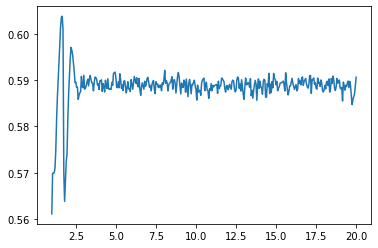

In [24]:
# Plot volumes
plt.plot(np.arange(1,20.05, 0.05), 4/3*np.pi*0.0005**3*384695/np.array(dem_volumes))

plt.show()

In [23]:
with open(rf"V:\GrNN_EDEM-Sims\Rot_drum_400k_data\Export_Data\dem_sim_plots\convex_hull_vols.npy", 'wb') as f:
    np.save(f, dem_volumes)

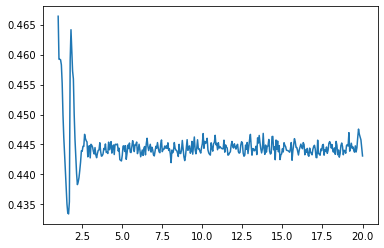

In [25]:
# Plot volumes
plt.plot(np.arange(1,20.05, 0.05), np.array(dem_volumes)/(np.pi*0.07**2*0.05))

plt.show()

In [29]:
np.array(dem_volumes)[0]/(np.pi*0.07**2*0.05)

0.4663992486879205

In [39]:
sum(value == 0 for value in id_dict.values())/384695

0.5002768426935624